<a href="https://colab.research.google.com/github/omarhashem80/2D_DCT/blob/main/2d_dct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔴Import Libraries 📦

In [ ]:
import os
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from math import log10

In [ ]:
class ImageCompressor:
    def __init__(self):
        pass

    @staticmethod
    def dct_2d(processed_block):
        """
        Computes the 2D Discrete Cosine Transform (DCT) of a given block.

        Parameters:
            processed_block (numpy.ndarray): Input block (8x8).

        Returns:
            numpy.ndarray: 2D DCT of the input block.
        """
        return dct(dct(processed_block.T, norm='ortho').T, norm='ortho')

    @staticmethod
    def idct_2d(processed_block):
        """
        Computes the inverse 2D Discrete Cosine Transform (IDCT) of a given block.

        Parameters:
            processed_block (numpy.ndarray): Input block (8x8).

        Returns:
            numpy.ndarray: Inverse 2D DCT of the input block.
        """
        return idct(idct(processed_block.T, norm='ortho').T, norm='ortho')

    @staticmethod
    def compress(image, m):
        """
        Compresses an image by retaining only the top-left m x m DCT coefficients of each 8x8 block.

        Parameters:
            image (numpy.ndarray): Input image (height x width x channels).
            m (int): Number of coefficients to retain.

        Returns:
            numpy.ndarray: Compressed image with retained DCT coefficients.
        """
        blocks_shape = (image.shape[0] // 8, image.shape[1] // 8)
        compressed_image = np.zeros((m * blocks_shape[0], m * blocks_shape[1], 3))
        for channel in range(3):
            for row in range(blocks_shape[0]):
                for col in range(blocks_shape[1]):
                    processed_block = image[8 * row:8 * (row + 1), 8 * col:8 * (col + 1), channel]
                    dct_block = ImageCompressor.dct_2d(processed_block)
                    dct_retained_block = dct_block[:m, :m]
                    compressed_image[m * row:m * (row + 1), m * col:m * (col + 1), channel] = dct_retained_block
        return compressed_image

    @staticmethod
    def decompress(compressed_image, m):
        """
        Decompresses an image by performing inverse DCT and reconstructing blocks.

        Parameters:
            compressed_image (numpy.ndarray): Compressed image with retained DCT coefficients.
            m (int): Number of coefficients retained during compression.

        Returns:
            numpy.ndarray: Decompressed image.
        """
        blocks_shape = (compressed_image.shape[0] // m, compressed_image.shape[1] // m)
        decompressed_image = np.zeros((8 * blocks_shape[0], 8 * blocks_shape[1], 3))
        for channel in range(3):
            for row in range(blocks_shape[0]):
                for col in range(blocks_shape[1]):
                    processed_block = np.zeros((8, 8))
                    processed_block[:m, :m] = compressed_image[m * row:m * (row + 1), m * col:m * (col + 1), channel]
                    idct_block = ImageCompressor.idct_2d(processed_block)
                    decompressed_image[8 * row:8 * (row + 1), 8 * col:8 * (col + 1), channel] = idct_block
        return decompressed_image

    @staticmethod
    def psnr(input_image, decompressed_image):
        """
        Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

        Parameters:
            input_image (numpy.ndarray): Original input image.
            decompressed_image (numpy.ndarray): Decompressed image.

        Returns:
            float: PSNR value.
        """
        SE = (input_image - decompressed_image) ** 2
        MSE = np.mean(SE)
        peak = 255
        PSNR = 10 * log10((peak ** 2) / MSE)
        return PSNR

    @staticmethod
    def visualize_components(input_image):
        """
        Visualizes and saves the color components of an image.

        Parameters:
            input_image (numpy.ndarray): Input image.

        Returns:
            None
        """
        os.makedirs("Image Components", exist_ok=True)
        colors = ["Reds", "Greens", "Blues"]
        for i in range(3):
            plt.figure(figsize=(14, 6))
            plt.axis("on")
            plt.imshow(input_image[:, :, 2 - i], cmap=colors[i])
            plt.axis("off")
            plt.savefig(f"Image Components/{colors[i][:-1].lower()} channel.png")

    @staticmethod
    def run():
        """
        Executes the project tasks including compression, decompression, PSNR calculation, and plotting.

        Parameters:
            None

        Returns:
            None
        """
        with open('sizes.txt', 'w') as file:
            input_image_array = cv2.imread("image1.png")
            ImageCompressor.visualize_components(input_image_array)
            os.makedirs("Decompressed Images", exist_ok=True)
            os.makedirs("Compressed Images", exist_ok=True)
            file.write(f"Original Image Size : {sys.getsizeof(input_image_array) / (1024 ** 2):.2f} MB\n")
            PSNRS = np.zeros(4)
            for m in range(1, 5):
                compressed_image = ImageCompressor.compress(input_image_array, m)
                np.save(f"Compressed Images/compressedImage_m{m}", compressed_image)
                decompressed_image = ImageCompressor.decompress(compressed_image, m)
                PSNR = ImageCompressor.write_image_info(file, sys.getsizeof(compressed_image.astype(np.float16)), input_image_array, decompressed_image.astype(np.uint8), m)
                PSNRS[m - 1] = PSNR
                cv2.imwrite(f"Decompressed Images/decompressedImage_m{m}.png", decompressed_image)
            all_ms = np.linspace(1, 4, 4, dtype=np.uint8)
            ImageCompressor.plot_PSNRS(all_ms, PSNRS)

    @staticmethod
    def write_image_info(file, size_in_bytes, input_image, decompressed_image, m):
        """
        Writes image compression information and PSNR value to a file.

        Parameters:
            file (file): File object to write information to.
            size_in_bytes (float): Size of the compressed image in bytes.
            input_image (numpy.ndarray): Original input image.
            decompressed_image (numpy.ndarray): Decompressed image.
            m (int): Number of coefficients retained during compression.

        Returns:
            float: PSNR value.
        """
        file.write(f"\n{'-' * 60} For m = {m} {'-' * 60}\n\n")
        file.write(f"\tCompressed Image Size: {size_in_bytes / (1024) ** 2:.2f} MB\n")
        PSNR = ImageCompressor.psnr(input_image, decompressed_image)
        file.write(f"\tPSNR: {PSNR:.2f} dB\n\n")
        file.write('-' * 120 + '\n\n')
        return PSNR

    @staticmethod
    def plot_PSNRS(all_ms, PSNRS):
        """
        Plots PSNR values against m values and saves the plot as an image.

        Parameters:
            all_ms (numpy.ndarray): Array of m values.
            PSNRS (numpy.ndarray): Array of PSNR values.

        Returns:
            None
        """
        plt.figure(figsize=(14, 6))
        plt.plot(all_ms, PSNRS, marker='o')
        plt.xlabel("m")
        plt.ylabel("PSNR")
        plt.savefig("PSNR_plot.png")


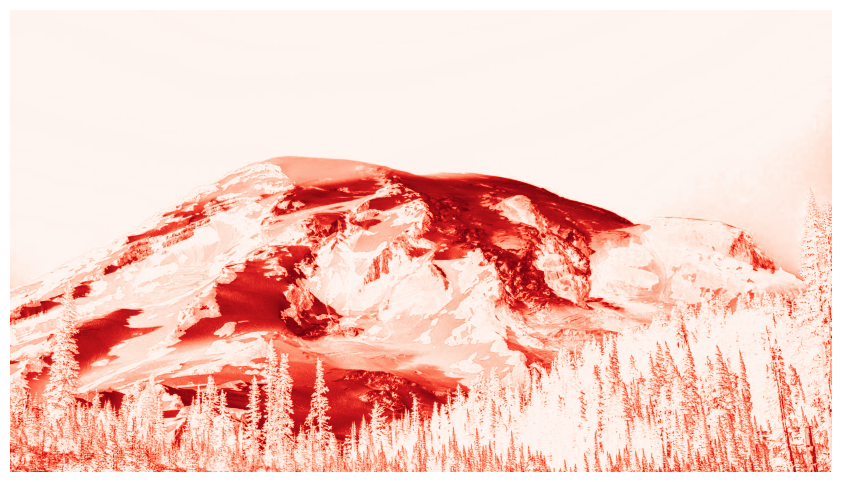

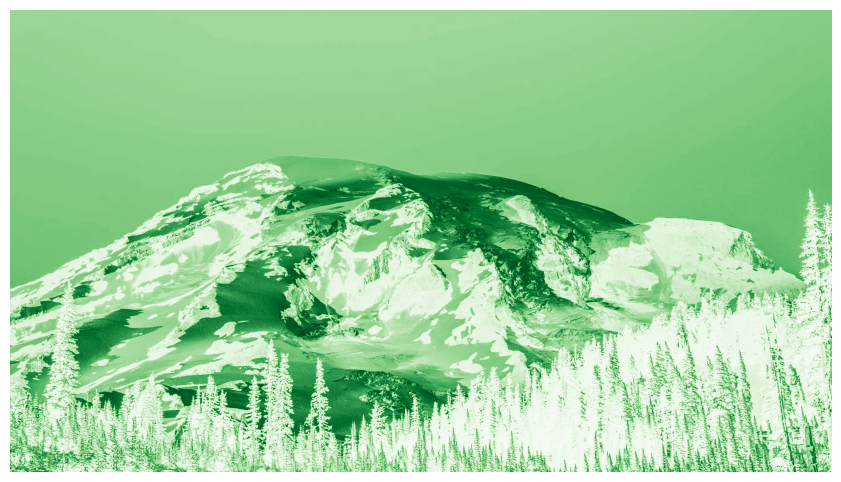

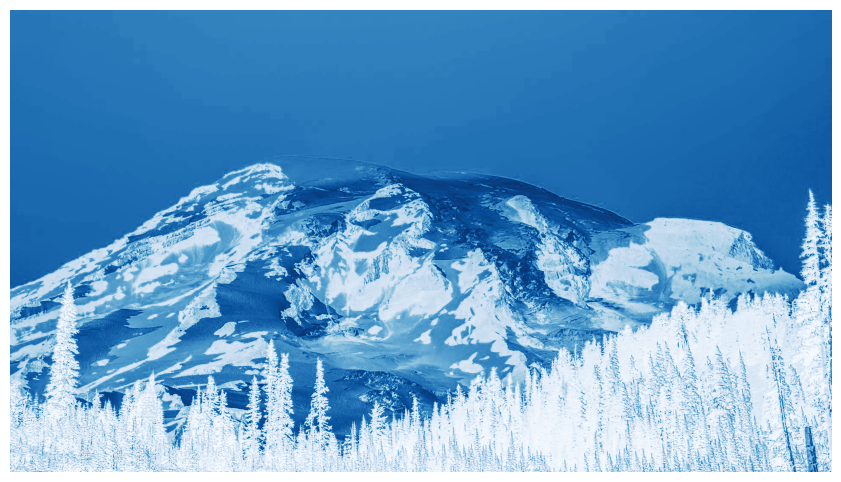

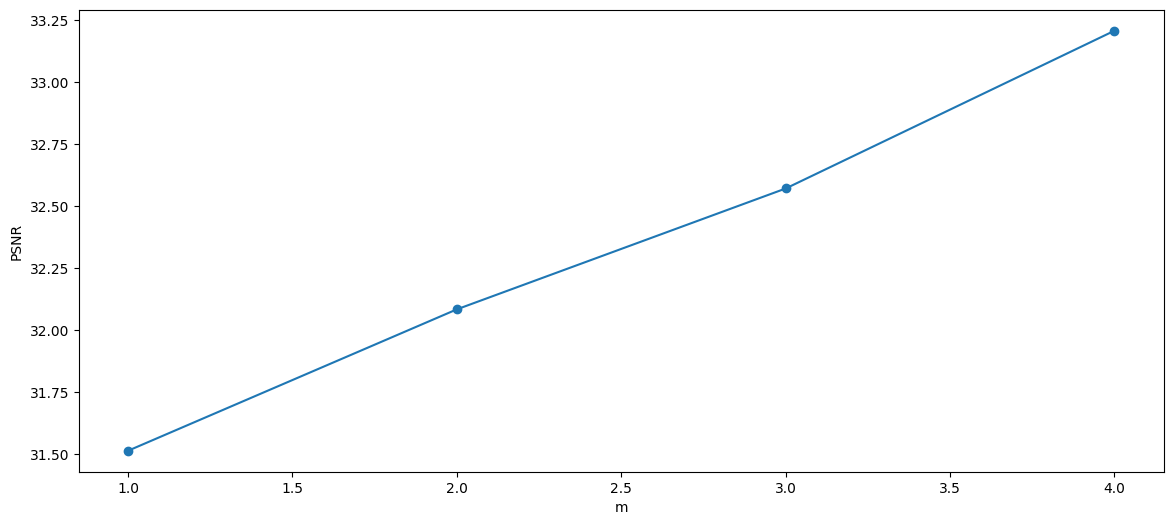

In [ ]:
ImageCompressor.run()